<a href="https://colab.research.google.com/github/remisoulignac/scm_optim_problems/blob/main/SC2X_Python_Samples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install ortools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Week 1 Practice Problem 4: SandyCo 
SandyCo has two (2) facilities that mine, clean, and sort sand for use in cement, children’s playboxes, and small beaches. They distribute the sand from their two (2) plants, through two (2) packaging centers (DCs), to three (3) different customer regions where it is packaged and sold.

Each plant has a specific maximum weekly supply of available sand and each region has an expected minimum weekly required demand. The cost to distribute a ton of sand differs between each plant and region pairing due to distance and other factors.

The maximum weekly supply from Plant 1 is 100 tons, from Plant 2 it is 125 tons. The expected minimum weekly required demand (in tons) is:

* Region 1: 25
* Region 2: 95
* Region 3: 80

The transportation costs in dollars per ton of sand are given in the table below.

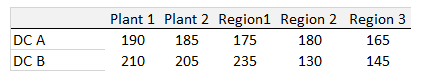


In [5]:
#https://learning.edx.org/course/course-v1:MITx+CTL.SC2x+1T2022/block-v1:MITx+CTL.SC2x+1T2022+type@sequential+block@988e14b25e02495ca975f4b33a06823e/block-v1:MITx+CTL.SC2x+1T2022+type@vertical+block@b880fbccfe944cfea74d5698b2ac77a5
from ortools.sat.python import cp_model
import numpy as np

INFINITY = cp_model.INT32_MAX
model = cp_model.CpModel()

#helper functions to deal with arrays
add_constraints_eq=np.vectorize(lambda e,c : model.Add(e==c))
add_constraints_ge=np.vectorize(lambda e,c : model.Add(e>=c))
add_constraints_le=np.vectorize(lambda e,c : model.Add(e<=c))
vararray_to_results=np.vectorize(lambda v:f'{v.Name()}={solver.Value(v)}')

#-- INPUTS
Plants= ['P1',  'P2']
PlantCapacity = [ 100,  125]
DCs = ['CA', 'CB']
Regions = ['R1',  'R2',   'R3']
Demand  = [ 25,   95,    80]

#Shape : DCs x Plants
InboundCosts  =  [
    [190, 185],
    [210, 205]
]
#Shape : DCs x Regions
OutboundCosts  = [
    [175, 180, 165],
    [235, 130, 145]
]

#- DECISIONS VARIABLES
#Shape : DCs x Plants
PlantToDC=np.asarray(list(list(model.NewIntVar(0, INFINITY,'{}->{}'.format(plant, dc)) for plant in Plants) for dc in DCs ))
#Shape : DCs x Regions 
DCToRegion=np.asarray(list(list(model.NewIntVar(0, INFINITY,'{}->{}'.format(dc, region)) for region in Regions) for dc in DCs))

#-- CONSTRAINTS
# max capacity for each plant is satisfied
add_constraints_le(np.sum(PlantToDC, axis=0), PlantCapacity)
# demand for each region is satisfied
add_constraints_ge(np.sum(DCToRegion, axis=0), Demand)
# inbound flow equals outputbound flow at DC
add_constraints_eq(np.sum(PlantToDC, axis=1), np.sum(DCToRegion, axis=1))

#-- OBJECTIVE FUNCTION
TotalCost = np.sum(PlantToDC*InboundCosts)+np.sum(DCToRegion*OutboundCosts)
model.Minimize(TotalCost)

#-- EXECUTION
solver = cp_model.CpSolver()
status = solver.Solve(model)
if status == cp_model.OPTIMAL:
    print("Objective=", solver.ObjectiveValue())
    print("PlantToDC=\n", vararray_to_results(PlantToDC))
    print("DCToRegion=\n", vararray_to_results(DCToRegion))
else:
    print('No optimal solution found.')


Objective= 69200.0
PlantToDC=
 [['P1->CA=75' 'P2->CA=0']
 ['P1->CB=0' 'P2->CB=125']]
DCToRegion=
 [['CA->R1=25' 'CA->R2=0' 'CA->R3=50']
 ['CB->R1=0' 'CB->R2=95' 'CB->R3=30']]


#Week 2 - Practice Problem 2: Papper
Papper is a paper goods manufacturer. One of their main paper products is a paper towel, which is produced in two (2) plants in the contiguous U.S. From the plants, the paper towels are sent to nine (9) regional warehouses (RW), from where they are then shipped to customers across the U.S.

The distribution manager at Papper wants to reduce the number of direct transports in the network, reduce the inventory levels at the plants, and move inventory closer to the regional warehouses, by introducing a central warehouse (CW) where all finished paper towels are stored before further shipment. That is, the idea is to have the towels flowing from the plants to the CW and then to the RWs. The CW will have a small safety stock, but everything that comes into the CW during a week should also leave the CW during that week.

The distribution manager has found five (5) candidate locations for the CW that he is now choosing between. Capacity is not an issue at any of them.

All data, including weekly demand data (in number of boxes), is found below :
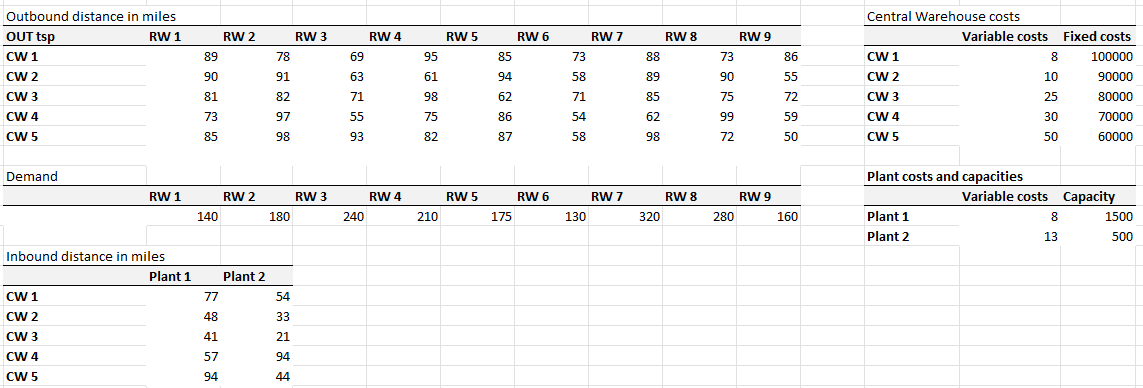

Assume transportation cost is $1 per mile per box of paper towels.

In [7]:
from ortools.sat.python import cp_model
import numpy as np

infinity = cp_model.INT32_MAX

model = cp_model.CpModel()

#helper functions to deal with arrays
add_constraint=model.Add
add_constraints_eq=np.vectorize(lambda e,c : model.Add(e==c))
add_constraints_ge=np.vectorize(lambda e,c : model.Add(e>=c))
add_constraints_le=np.vectorize(lambda e,c : model.Add(e<=c))
vararray_to_results=np.vectorize(lambda v:f'{v.Name()}={solver.Value(v)}')

#Facilities
Central_Warehouse=['CW1','CW2','CW3','CW4','CW5']
Production=['Plant1','Plant2']
Regional_Warehouse=['RW1','RW2','RW3','RW4','RW5','RW6','RW7','RW8','RW9']

#Constants
#shape : Central_Warehouse X Regional_Warehouse
Outbound_Distances=[
  [89,  78, 69, 95, 85, 73, 88, 73, 86],
  [90,  91, 63, 61, 94, 58, 89, 90, 55],
  [81,  82, 71, 98, 62, 71, 85, 75, 72],
  [73,  97, 55, 75, 86, 54, 62, 99, 59],
  [85,  98, 93, 82, 87, 58, 98, 72, 50]
]

#shape : Central_Warehouse X Regional_Warehouse
Under_Seventy_Miles=(np.array(Outbound_Distances)<=70).astype(int).tolist()

#shape : Central_Warehouse X Production
Inbound_Distances=[
  [77, 54],
  [48, 33],
  [41, 21],
  [57, 94],
  [94, 44]
]

Regional_Warehouse_Demand=[140, 180, 240, 210, 175, 130, 320, 280, 160]
Central_Warehouse_VC=[8, 10, 25, 30, 50]
Central_Warehouse_FC=[100000, 90000, 80000, 70000, 60000]
Production_VC=[8, 13]
Production_Capacity=[1500, 500]

#Decision variables
Use_Central_Warehouse=np.asarray(list(model.NewBoolVar(cw) for cw in Central_Warehouse))
Amt_Inbound=np.asarray(list(list(model.NewIntVar(0, infinity, prod+"->"+cw) for prod in Production) for cw in Central_Warehouse))
Amt_Outbound=np.asarray(list(list(model.NewIntVar(0, infinity, cw+"->"+rw) for rw in Regional_Warehouse) for cw in Central_Warehouse))

#Objective function
model.Minimize(
    np.sum(Use_Central_Warehouse*Central_Warehouse_FC)+
    np.sum(Amt_Inbound*Inbound_Distances)+
    np.sum(Amt_Outbound*Outbound_Distances)+
    np.sum(np.sum(Amt_Inbound, axis=1)*Central_Warehouse_VC)+
    np.sum(Amt_Inbound*Production_VC)
)

#Constraints
Bounded_Nb_CW=add_constraint(np.sum(np.array(Use_Central_Warehouse))>=1)
Meet_Demand=add_constraints_eq(np.sum(Amt_Outbound, axis=0), Regional_Warehouse_Demand)
Inflow_Equal_Outflow = add_constraints_eq(np.sum(Amt_Inbound, axis=1), np.sum(Amt_Outbound, axis=1))
Enforce_Production_Capacity = add_constraints_le(np.sum(Amt_Inbound, axis=0), Production_Capacity)
Only_Flow_Through_Operating_Central_Warehouse=add_constraints_le(np.sum(Amt_Inbound, axis=1), Use_Central_Warehouse*np.sum(Regional_Warehouse_Demand))
Demand_Seventy_Miles=np.sum(Amt_Outbound*Under_Seventy_Miles)
Sixty_Pct_Demand_Seventy_Miles = add_constraint(Demand_Seventy_Miles >= round(0.6*np.sum(Regional_Warehouse_Demand)))

#Solution
solver = cp_model.CpSolver()
status = solver.Solve(model)

if status == cp_model.OPTIMAL:
  print("Objective=", solver.ObjectiveValue())
  print("Use_Central_Warehouse=", vararray_to_results(Use_Central_Warehouse))
  print("Amt_Outbound=", vararray_to_results(Amt_Outbound))
  print("% within 70 miles=", solver.Value(Demand_Seventy_Miles)/np.sum(Regional_Warehouse_Demand))

Objective= 490882.0
Use_Central_Warehouse= ['CW1=0' 'CW2=1' 'CW3=1' 'CW4=1' 'CW5=0']
Amt_Outbound= [['CW1->RW1=0' 'CW1->RW2=0' 'CW1->RW3=0' 'CW1->RW4=0' 'CW1->RW5=0'
  'CW1->RW6=0' 'CW1->RW7=0' 'CW1->RW8=0' 'CW1->RW9=0']
 ['CW2->RW1=0' 'CW2->RW2=0' 'CW2->RW3=240' 'CW2->RW4=210' 'CW2->RW5=0'
  'CW2->RW6=130' 'CW2->RW7=134' 'CW2->RW8=0' 'CW2->RW9=160']
 ['CW3->RW1=140' 'CW3->RW2=180' 'CW3->RW3=0' 'CW3->RW4=0' 'CW3->RW5=175'
  'CW3->RW6=0' 'CW3->RW7=0' 'CW3->RW8=280' 'CW3->RW9=0']
 ['CW4->RW1=0' 'CW4->RW2=0' 'CW4->RW3=0' 'CW4->RW4=0' 'CW4->RW5=0'
  'CW4->RW6=0' 'CW4->RW7=186' 'CW4->RW8=0' 'CW4->RW9=0']
 ['CW5->RW1=0' 'CW5->RW2=0' 'CW5->RW3=0' 'CW5->RW4=0' 'CW5->RW5=0'
  'CW5->RW6=0' 'CW5->RW7=0' 'CW5->RW8=0' 'CW5->RW9=0']]
% within 70 miles= 0.6


#Week 1 - Facility Location Models
Study the influence of number of warehouses vs  % customers within a distance and total costs

Matrix approach

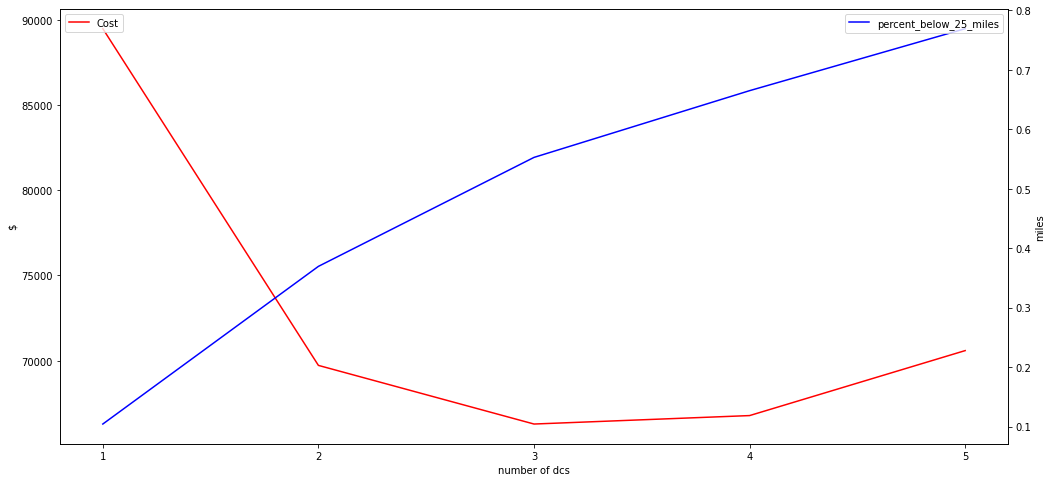

In [18]:
#SC2X - Facility Location
#https://learning.edx.org/course/course-v1:MITx+CTL.SC2x+2T2021/block-v1:MITx+CTL.SC2x+2T2021+type@sequential+block@1182d5881b294f82b5bdd32c7ca730a9/block-v1:MITx+CTL.SC2x+2T2021+type@vertical+block@e2e2a49def304675af8e630cf1b8789c
from ortools.linear_solver import pywraplp
import numpy as np
import matplotlib.pyplot as plt

infinity = float('inf')
def create_data_model(min_dc=1, max_dc=1):
  """Stores the unitdata for the problem."""
  data = {}

  #organization of V, matrix of the decision variables 
  #it will be constructed later from the objective coefficient matrix
  #            Open	BO BR CO HA MN NA NH NL PO PR SP WO
  # BO              
  # NA
  # PR
  # SP
  # WO

  #matrix O, objective function coefficients
  # the solver with try to minimize or maximize the grand sum of the matrix product of V by O
  data['obj_coeffs'] = [
   [10000,  0,  93,  69,  98, 55, 37, 128,  95,  62, 42, 82, 34],
   [10000, 37,  65,  33, 103, 20,  0, 137, 113,  48, 72, 79, 41],
   [10000, 42, 106, 105,  73, 92, 72,  94,  57, 104,  0, 68, 38],
   [10000, 82,  59, 101,  27, 93, 79,  63,  57, 127, 68,  0, 47],
   [10000, 34,  68,  72,  66, 60, 41,  98,  71,  85, 38, 47,  0]
   ]

  #define the constraints
  #format : array of tuples, each tuple defining a constraint
  #each constraint is defined as : (C, min, max) with C a matrix conforming the variable matrix
  #the solver ensures that :  min <= grand sum of the matrix product of V by C <= max  
  data['constraint_coeffs_min_max'] = [  
     #Define the Open variable as a binary variable (integer = 0 or 1)
     ([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 0, 1),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 0, 1),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 0, 1),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 0, 1),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 0, 1),

     # maximum number of opened warehouses
     ([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], min_dc, max_dc),

     #demand constraints
     ([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 425, infinity),
     ([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 12, infinity),      
     ([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 43, infinity),
     ([[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], 125, infinity),      
     ([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], 110, infinity),
     ([[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]], 86, infinity),
     ([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], 129, infinity),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]], 28, infinity),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]], 66, infinity),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]], 320, infinity),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]], 220, infinity),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], 182, infinity),      

    # link constraint between having the warehouse opened and being able to deliver
     ([[-5000, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], -infinity, 0),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [-5000, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], -infinity, 0),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [-5000, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], -infinity, 0),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [-5000, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], -infinity, 0),
     ([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [-5000, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], -infinity, 0),
  ]

  return data



def solve(data):
  # Create the mip solver with the SCIP backend.
  solver = pywraplp.Solver.CreateSolver('SAT')

  #deduce the array x[j,i] of the decision variables from the objective coeficient matrix
  #each variable is defined as positive integer
  x=[[solver.IntVar(0, infinity, f'x[{j},{i}]') for i in range(len(data['obj_coeffs'][j]))] for j in range(len(data['obj_coeffs']))] 
  #initialize the constraints
  for c in data['constraint_coeffs_min_max']:
    constraint = solver.RowConstraint(c[1], c[2], '')
    for ji,v in np.ndenumerate(c[0]):
      constraint.SetCoefficient(x[ji[0]][ji[1]], v*1.0)

  #initialize the coefficients
  objective = solver.Objective()
  for ji,v in np.ndenumerate(data['obj_coeffs']):
    objective.SetCoefficient(x[ji[0]][ji[1]], v*1.0)

  objective.SetMinimization()
  status = solver.Solve()
  if status == pywraplp.Solver.OPTIMAL:
    return (solver.Objective().Value(), np.vectorize(lambda x:x.solution_value())(x), np.array(data['obj_coeffs']))
  else:
    raise('The problem does not have an optimal solution.')

nb_dcs=range(1,6)
costs=[]
avg_customer_distances=[]
percent_below_25_miles=[]
for nb_dc in nb_dcs:
  data=create_data_model(nb_dc, nb_dc)
  #results = Objective value, Decision variables, Coefficients
  O, X, C=solve(data)
  costs.append(O)
  #activated routes
  R=(X[:,1:]>0).astype(int)
  avg_customer_distances.append(np.sum(R*C[:,1:], axis=None) / np.sum(R, axis=None))
  #compute by removing the first column (=Decision variable for opening warehouse)
  below_25_miles_test = np.vectorize(lambda d: 1 if d <= 25 else 0)
  percent_below_25_miles.append(np.sum(X[:,1:]*below_25_miles_test(C[:,1:]), axis=None) / np.sum(X[:,1:], axis=None))

f, ax = plt.subplots(1,figsize=(17,8))
ax.set_xlabel('number of dcs')
ax.set_ylabel("$")
ax.plot(nb_dcs, costs, label='Cost', color="red")
ax.legend(loc='upper left')
plt.xticks(nb_dcs)
ax = ax.twinx() 
ax.set_ylabel("miles")
ax.plot(nb_dcs, percent_below_25_miles, label='percent_below_25_miles', color="blue")
#ax.plot(nb_dcs, avg_customer_distances, label='avg_customer_distances', color="green")
ax.legend(loc='upper right')
plt.show()

#Week 2 - Practice Problem 5: RCH Industries' Differentiation
This exercice showcases that optimal solution may not be unique :)

Ralph Calvin Hilfiger (RCH) Industries - the clothing manufacturer from Week 1 - has found that different clothing styles have very different demands in the five (5) markets. For instance, the more stylish items sell relatively more in Europe, while the more leisurely items seem to do much better in the U.S. To accommodate this, they want to update the network design, and rethink the product mix produced in each of the five factories.

As before, RCH distributes their products from their five (5) factories through (2) cross docking facilities (XD) on to five (5) regional distribution centers (DCs), each of which supports a specific market. The clothes are transported through the network in small plastic totes via truck. There are no capacity constraints at the cross docks at this point.

RCH has grouped their clothing items into two major style categories: Stylish and Leisure. The demand for the categories in the five markets, as well as production capacities and transportation costs are found here
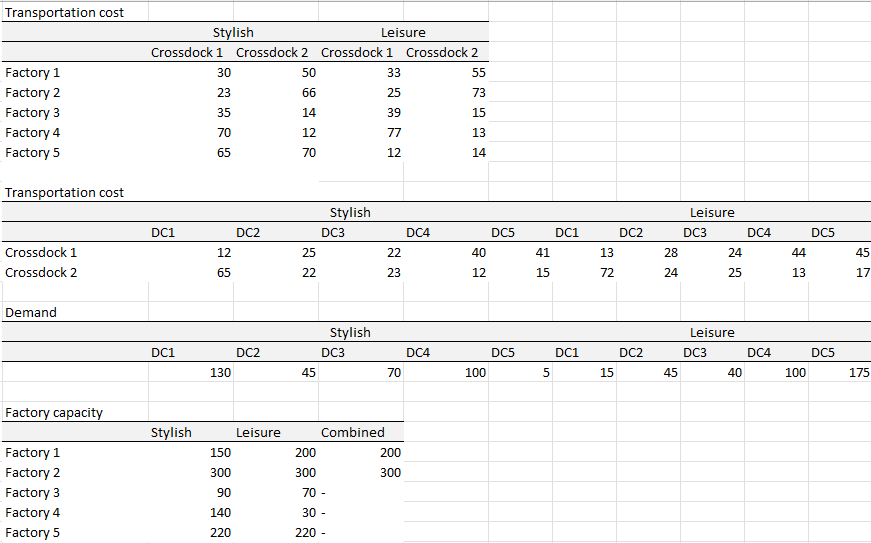

In [ ]:
from ortools.sat.python import cp_model
import numpy as np

infinity = cp_model.INT32_MAX

model = cp_model.CpModel()

#helper functions to deal with arrays
add_constraint=model.Add
add_constraints_eq=np.vectorize(lambda e,c : model.Add(e==c))
add_constraints_ge=np.vectorize(lambda e,c : model.Add(e>=c))
add_constraints_le=np.vectorize(lambda e,c : model.Add(e<=c))
vararray_to_results=np.vectorize(lambda v:f'{v.Name()}={solver.Value(v)}')

#Facilities
Cross_Dock=['XD1', 'XD2']
Production=['Factory1','Factory2', 'Factory3', 'Factory4', 'Factory5']
Distribution_Center=['DC1','DC2','DC3','DC4','DC5']
Category=['Stylish', 'Leisure']

#Constants
#shape : Production X Category X Cross_Dock 
Inbound_Distances=[
 [[30, 50],
  [33, 55]],
 [[23, 66],
  [25, 73]],
 [[35, 14],
  [39, 15]],
 [[70, 12],
  [77, 13]],
 [[65, 70],
  [12, 14]]
]

#shape : Cross_Dock  X Category X Distribution_Center
Outbound_Distances=[
 [
  [12, 25,	22,	40,	41],
  [13, 28,	24,	44,	45]
 ],
 [
  [65,	22,	23,	12,	15],
  [72,	24,	25,	13,	17]
 ]
]


#shape Category X Distribution_Center
Distribution_Center_Demand=[
  [130,	45,	70,	100,	5],
  [15,	45,	40,	100,	175]
]

#shape Production X Category
Production_Capacity=[
  [150, 200],
  [300,	300],
  [90, 	70],
  [140,	30],
  [220,	220]
]
#shape Production
Combined_Production_Capacity=[
  200, 
  300, 
  100, 
  150, 
  220            
]

#Decision variables
#shape Production X Category X Cross_Dock 
Amt_Inbound=np.asarray(list(list(list(model.NewIntVar(0, infinity, f'{cat}: {prod}->{xd}') for xd in Cross_Dock)  for cat in Category) for prod in Production) )
#shape Cross_Dock  X Category X Distribution_Center
Amt_Outbound=np.asarray(list(list(list(model.NewIntVar(0, infinity, f'{cat}: {xd}->{dc}') for dc in Distribution_Center) for cat in Category) for xd in Cross_Dock))


#Constraints
Meet_Demand=add_constraints_eq(np.sum(Amt_Outbound, axis=0), Distribution_Center_Demand)
Inflow_Equal_Outflow = add_constraints_eq(np.sum(Amt_Inbound, axis=0), np.transpose(np.sum(Amt_Outbound, axis=2)))
#Enforce_Production_Capacity = add_constraints_le(np.sum(Amt_Inbound, axis=2), Production_Capacity)
Enforce_Production_Combined_Capacity= add_constraints_le(np.sum(Amt_Inbound, axis=(1,2)), Combined_Production_Capacity)
ObjectiveFunction = np.sum(Amt_Inbound*Inbound_Distances)+np.sum(Amt_Outbound*Outbound_Distances)
#when looking for all solutions, we have to set the target objective function
Target_Minimum=add_constraint(ObjectiveFunction == 24230)

class SolutionRecorder(cp_model.CpSolverSolutionCallback):
    """Print intermediate solutions."""
    def __init__(self):
        cp_model.CpSolverSolutionCallback.__init__(self)
        self.solutions=[]
    def on_solution_callback(self):
      self.solutions.append(np.vectorize(lambda v:self.Value(v))(Amt_Inbound).tolist())

#Solution
solver = cp_model.CpSolver()
solution_recorder = SolutionRecorder()
status = solver.SearchForAllSolutions(model, solution_recorder)
#shape Solution X Production X Category X Cross_Dock
sols = np.asarray(solution_recorder.solutions)
print(f'Number of solutions found: {len(sols)}' )
print(f'Solutions status: {solver.StatusName(status)}')
#shape Solution X Production X Category
sols_cat_prod = np.sum(sols, axis=3)
sols_cat_prod_not_zero = (sols_cat_prod>0).astype(int)
#shape Solution X Production
sols_is_not_used = (np.sum(sols_cat_prod_not_zero, axis=2)==0).astype(int)
sols_nb_is_not_used = np.sum(sols_is_not_used, axis=1)
sols_is_specialized = (np.sum(sols_cat_prod_not_zero, axis=2)==1).astype(int)
sols_nb_is_specialized = np.sum(sols_is_specialized, axis=1)
print("distribution of the solutions over the number of factories not used")
print(np.histogram(sols_nb_is_not_used, bins=(0, 1, 2, 3, 4, 5)))
print("distribution of the solutions over the number of factories specialized")
print(np.histogram(sols_nb_is_specialized, bins=(0, 1, 2, 3, 4, 5)))
print("unique solution with 3 specialized factories (Inbound with shape: Production X Category X Cross_Dock) ")
print(sols[np.where(sols_nb_is_specialized==3)])

Number of solutions found: 4646
Solutions status: OPTIMAL
distribution of the solutions over the number of factories not used
(array([   0, 4646,    0,    0,    0]), array([0, 1, 2, 3, 4, 5]))
distribution of the solutions over the number of factories specialized
(array([   0, 4554,   91,    1,    0]), array([0, 1, 2, 3, 4, 5]))
unique solution with 3 specialized factories (Inbound with shape: Production X Category X Cross_Dock) 
[[[[  0   0]
   [  0   0]]

  [[200   0]
   [ 55   0]]

  [[  0   0]
   [  0 100]]

  [[  0 150]
   [  0   0]]

  [[  0   0]
   [  0 220]]]]


i= 0 Objective= 5404.5 QtyProduced= ['P0=0' 'P1=6412' 'P2=0' 'P3=9369' 'P4=0' 'P5=0' 'P6=6156' 'P7=0'
 'P8=7663' 'P9=0' 'P10=0']
i= 1 Objective= 5520.7 QtyProduced= ['P0=0' 'P1=5930' 'P2=0' 'P3=5925' 'P4=0' 'P5=8992' 'P6=0' 'P7=0'
 'P8=8753' 'P9=0' 'P10=0']
i= 2 Objective= 5526.6 QtyProduced= ['P0=0' 'P1=6053' 'P2=0' 'P3=8668' 'P4=0' 'P5=0' 'P6=7611' 'P7=0' 'P8=0'
 'P9=7267' 'P10=0']
i= 3 Objective= 5534.5 QtyProduced= ['P0=0' 'P1=5950' 'P2=0' 'P3=6294' 'P4=0' 'P5=7846' 'P6=0' 'P7=0'
 'P8=9510' 'P9=0' 'P10=0']
i= 4 Objective= 5098.0 QtyProduced= ['P0=0' 'P1=6369' 'P2=0' 'P3=8951' 'P4=0' 'P5=0' 'P6=6061' 'P7=0'
 'P8=8219' 'P9=0' 'P10=0']
i= 5 Objective= 5429.7 QtyProduced= ['P0=0' 'P1=5953' 'P2=0' 'P3=6053' 'P4=0' 'P5=5756' 'P6=0' 'P7=5449'
 'P8=0' 'P9=6390' 'P10=0']
i= 6 Objective= 5366.2 QtyProduced= ['P0=0' 'P1=6406' 'P2=0' 'P3=6967' 'P4=0' 'P5=8747' 'P6=0' 'P7=0'
 'P8=7480' 'P9=0' 'P10=0']
i= 7 Objective= 5528.9 QtyProduced= ['P0=0' 'P1=8789' 'P2=0' 'P3=0' 'P4=5893' 'P5=0' 'P6=8113'

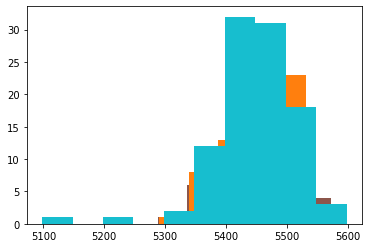

In [ ]:
#SC2X - https://learning.edx.org/course/course-v1:MITx+CTL.SC2x+2T2021/block-v1:MITx+CTL.SC2x+2T2021+type@sequential+block@ecafd0b1418f446e922bd663805a561c/block-v1:MITx+CTL.SC2x+2T2021+type@vertical+block@ecf8d1d5509a4757a778bbf86c2cc306#Study of Optima
#Practice Problem 2: Sodaco
#Study of sensitiviy of optimal solution

from ortools.sat.python import cp_model
import matplotlib.pyplot as plt
import numpy as np

infinity = cp_model.INT32_MAX

model = cp_model.CpModel()

#helper functions to deal with arrays
add_constraint=model.Add
add_constraints_eq=np.vectorize(lambda e,c : model.Add(e==c))
add_constraints_ge=np.vectorize(lambda e,c : model.Add(e>=c))
add_constraints_le=np.vectorize(lambda e,c : model.Add(e<=c))
vararray_to_results=np.vectorize(lambda v:f'{v.Name()}={solver.Value(v)}')

objectives=np.zeros(shape=(0))
qtiesProduced=np.zeros(shape=(0,11))

for i in range(100):
  Period = [0,1,2,3,4,5,6,7,8,9,10]
    
  Capacity = 99999;

  #shape : Period
  Demand_µ =         [0, 3000, 3100, 3200, 3100, 2900, 2800, 2800, 2900, 2800, 3000]
  VariationCoeff = [0, 0   , 0.02, 0.04, 0.08,  0.1, 0.12, 0.14, 0.16, 0.18, 0.20]

  Demand=np.random.default_rng().normal(loc=Demand_µ, scale=np.array(Demand_µ)*np.array(VariationCoeff))
  Demand=Demand*np.sum(Demand_µ)/np.sum(Demand)
  Demand=np.round(Demand).astype(int)

  HoldingCost = 1
  SetupCost = 8000
  M = np.sum(Demand)
  MinRunQty = 0

  #Decision variables
  #shape Production X Category X Cross_Dock 
  Inventory=np.asarray(list(model.NewIntVar(0, infinity, f'P{period}') for period in Period))
  Production=np.asarray(list(model.NewIntVar(0, 1, f'P{period}') for period in Period))
  QtyProduced=np.asarray(list(model.NewIntVar(0, infinity, f'P{period}') for period in Period))

  #Objective function
  model.Minimize(
      np.sum(Inventory*HoldingCost)+
      np.sum(Production*SetupCost)
  )

  #Constraints
  StartingInventory=add_constraint(Inventory[0]==0)
  MfgCapacity=add_constraints_le(QtyProduced, Capacity)
  LinkCon=add_constraints_le(QtyProduced, Production*M)
  FlowCon=add_constraints_eq(QtyProduced[1:]-Demand[1:]+Inventory[:-1]-Inventory[1:], 0)
  MinRunCon=add_constraints_ge(QtyProduced, -MinRunQty*Production);

  #Solution
  solver = cp_model.CpSolver()
  status = solver.Solve(model)

  if status == cp_model.OPTIMAL:
    print("i=", i, "Objective=", solver.ObjectiveValue()/10, "QtyProduced=", vararray_to_results(QtyProduced))
    objectives=np.append(objectives, solver.ObjectiveValue()/10)
    qtiesProduced=np.append(qtiesProduced, [np.vectorize(lambda v:solver.Value(v))(QtyProduced)], axis=0)

  plt.hist(objectives)